# Learning objectives

In this Exercise, we will see how to: 

- Visualize volumes and segmentations using matplotlib, matshow3d, itkwidget and tensorboard. 

# Install dependencies

In [1]:
#@formatter:off
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==1.2.0"
!python -c "import itkwidgets" || pip install -q itkwidgets
!python -c "import tensorboard_plugin_3d" || pip install -q tensorboard-plugin-3d
#@formatter:on

%matplotlib inline

# Verify your Configuration

Execute the following cell to check MONAI's configuration using MONAI's `print_config()`.

In [3]:
from monai.config import print_config

print_config()

MONAI version: 1.2.0
Numpy version: 1.26.1
Pytorch version: 2.1.0+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: C:\Work\Projects\2023_10_19_Formation_Medical_AI_EPITA\venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.22.0
Pillow version: 10.1.0
Tensorboard version: 2.14.1
gdown version: 4.7.1
TorchVision version: 0.16.0+cpu
tqdm version: 4.66.1
lmdb version: 1.4.1
psutil version: 5.9.6
pandas version: 2.1.1
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.7.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies


# Creating Toy Data and Temp Directory for Examples

We'll create a temporary directory and populate it with a few example Nifti file-format images containing a random assortment of spheres.  We're also creating a matching segmentation pair that will be used later in the notebook.

In [4]:
from monai.data import create_test_image_3d
import tempfile
import nibabel as nib
import numpy as np

fn_keys = ("image", "label")  # filename keys for image and seg files

root_dir = tempfile.mkdtemp()
print("Output temporary directory : ", root_dir)

filenames = []

for i in range(5):
    im, seg = create_test_image_3d(128, 128, 128, num_objs=16, rad_max=25, noise_max=.2)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"image": im_filename, "label": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

Output temporary directory :  C:\Users\Thibault\AppData\Local\Temp\tmpykyfb6ha


# Setup  MONAI transforms

In [5]:
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd, GaussianSmoothd, RandGaussianNoised

transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        GaussianSmoothd(keys=["image"], sigma=3),
        RandGaussianNoised(keys=["image"], prob=1, mean=.1, std=0.02),
        NormalizeIntensityd(keys=["image"])
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


# Visualize the image with MONAI matshow3d API

1. Load the first image and segmentation in the created files
2. Display the first image content using the `matshow3D` API. Plot every 8 frames
3. Display as a second subplot the segmentation using the `matshow3D` API.


torch.Size([1, 1, 128, 128, 128])


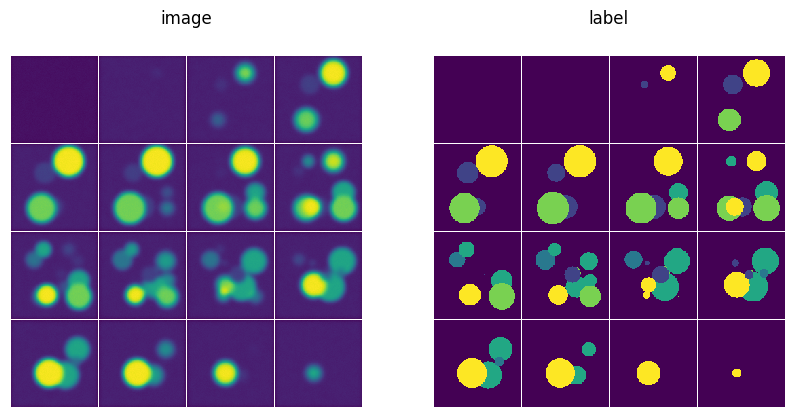

In [6]:
from monai.visualize.utils import matshow3d
from matplotlib import pyplot as plt
from monai.data import Dataset, DataLoader
from monai.utils import first

ds = Dataset(transform=transform, data=filenames)
data =  first(DataLoader(ds, batch_size=1))

print(data["image"].shape)
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
fig_img = matshow3d(data["image"], title="image", fig=plt.gca(), every_n=8)
plt.subplot(1, 2, 2)
fig_seg = matshow3d(data["label"], title="label", fig=plt.gca(), every_n=8)

# Visualize the 3D image in TensorBoard as GIF images

1. Use MONAI's `plot_2d_or_3d_image` to output the image as a GIF to TensorBoard

In [7]:
import os
from monai.visualize import plot_2d_or_3d_image
from monai.visualize.img2tensorboard import SummaryWriter

tb_dir = os.path.abspath("./Outputs/tensorboard_dir")
plot_2d_or_3d_image(data=data["image"], step=0, writer=SummaryWriter(log_dir=tb_dir, purge_step=True))

In [8]:
%load_ext tensorboard
%tensorboard --logdir=$tb_dir

Launching TensorBoard...

# Visualize using itkwidgets

1. Import view from the itkwidgets module
2. Display only the scalar data of the image as the `image` input and only the scalar data for the `label_image` input
3. Rescale the values by 255
4. Set the `gradient_opacity` to 0.4

In [9]:
from itkwidgets import view

view(image=data["image"][0, 0, :, :, :] * 255, label_image=data["label"][0, 0, :, :, :] * 255, gradient_opacity=0.4)

Viewer(geometries=[], gradient_opacity=0.4, interpolation=False, point_sets=[], rendered_image=<itk.itkImagePy…

# Visualize blended label image

1. Use MONAI's `blend_images` to blend the image and label from the data with an alpha of 0.2
2. Check the output shape of the blended image
3. Display the blended image


In [10]:
from monai.visualize import blend_images

ret = blend_images(image=data["image"][0], label=data["label"][0], alpha=0.2)
print(ret.shape)

torch.Size([3, 128, 128, 128])


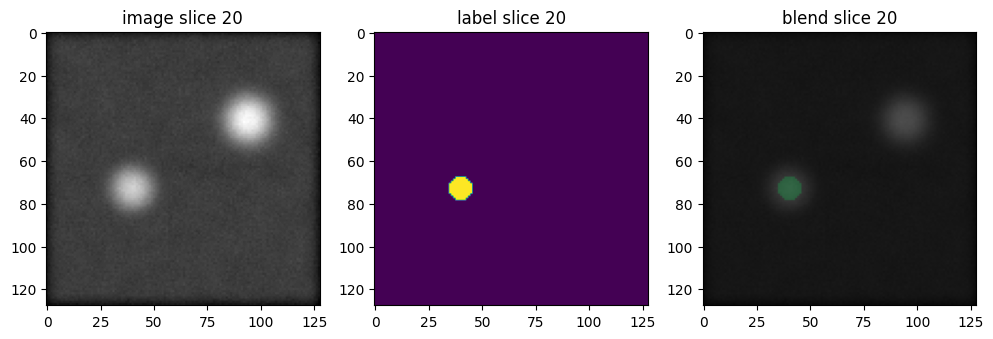

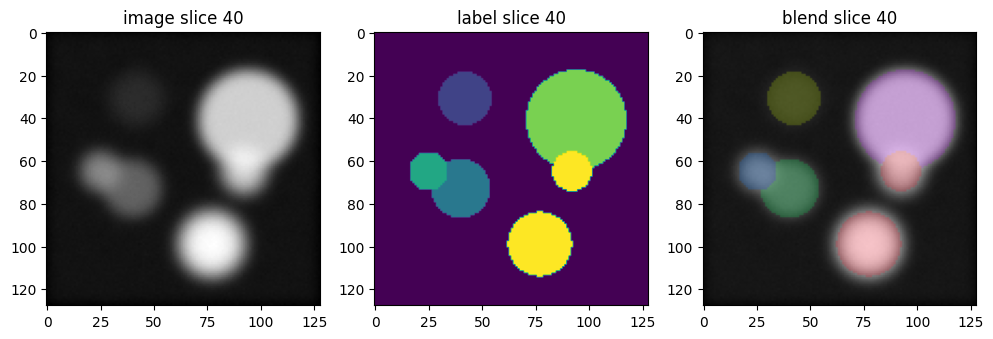

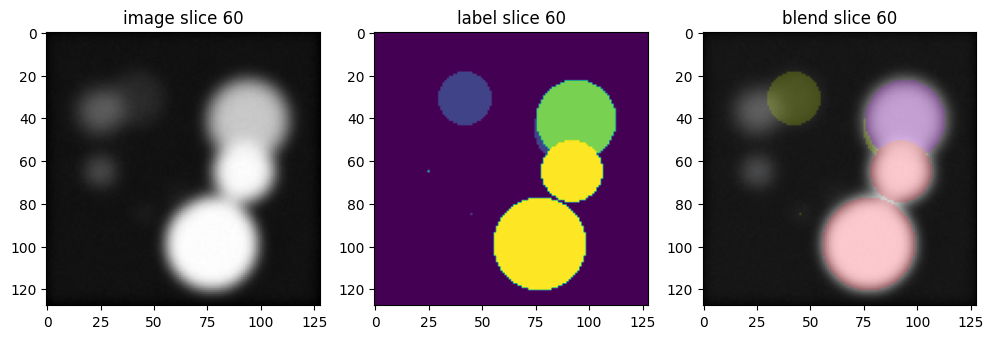

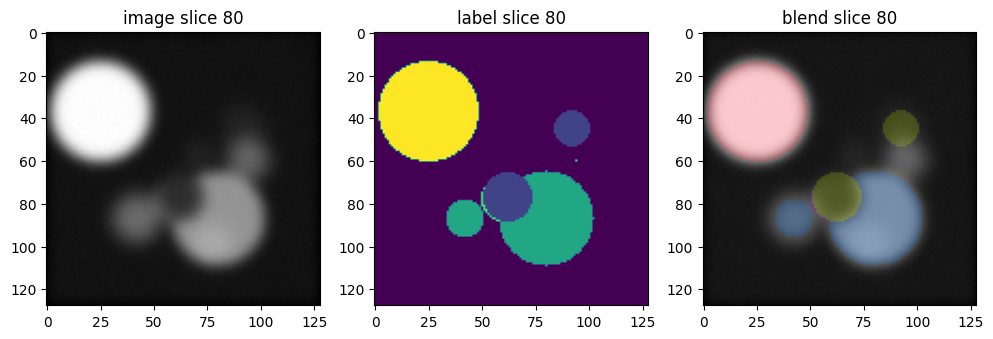

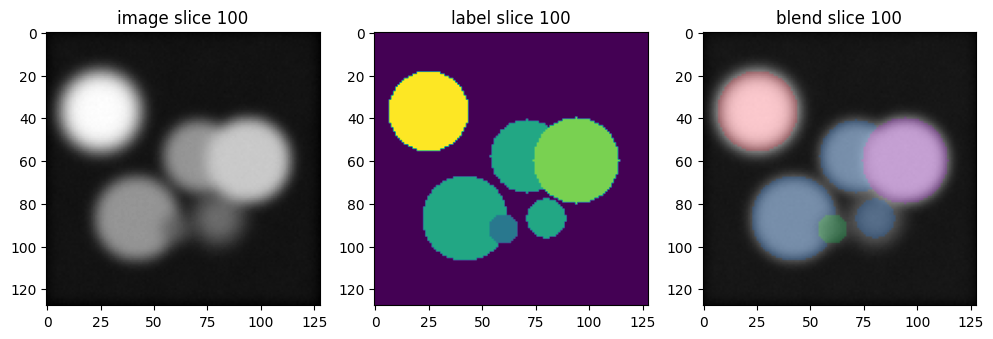

In [11]:
import torch

for i in range(1, 6):
    slice_index = 20 * i
    plt.figure("blend image and label", (12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"image slice {slice_index}")
    plt.imshow(data["image"][0, 0, :, :, slice_index], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"label slice {slice_index}")
    plt.imshow(data["label"][0, 0, :, :, slice_index])
    plt.subplot(1, 3, 3)
    plt.title(f"blend slice {slice_index}")
    # switch the channel dim to the last dim
    plt.imshow(torch.moveaxis(ret[:, :, :, slice_index], 0, -1))
    plt.show()

# Visualize the image with TensorBoardPlugin3D

1. Using MONAI's `plot_2d_or_3d_image` save images with tag `image`
2. Save label with tag `label`
3. Open tensorboard and visualize image and label in the `TensorBoard 3D` plugin (works best in Firefox)

In [12]:
tb_dir = "./Outputs/tensorboard_dir/images_with_labels"
sw = SummaryWriter(log_dir=tb_dir)
plot_2d_or_3d_image(data=data["image"], step=0, writer=sw, frame_dim=-1, tag="image")
plot_2d_or_3d_image(data=data["label"], step=0, writer=sw, frame_dim=-1, tag="label")

In [13]:
%load_ext tensorboard
%tensorboard --logdir=$tb_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...